# Tasks Description

The goal for both tasks is to analyze an audio recording provided in the file `audio.wav`.  
The recording contains the synthetic signals in the form of sinusoids with increasing frequency, present on both channels of `audio.wav`.  
  
The purpose of the exercise is to **locate impulses** within the channels.
A reference impulse is provided in the file `pulse.csv`

**Task 1**:  
Calculate correlation in the time domain and locate impulses within the channels.  
  
**Task 2**:
Calculate correlation in the frequency domain and locate impulses within the channels.  
  

At the end we will compare the charts of the calculated correlation from task 1 and 2.

## Task 1

### Loading provided audio

The audio signal is loaded from the file `audio.wav` and then separated into two channels (channel_1 and channel_2).

In [128]:
from scipy.io import wavfile
import numpy as np

# Load audio
fs, signal = wavfile.read('audio.wav')

# Extract channels
channel_1 = signal[:, 0]
channel_2 = signal[:, 1]

# Define time vector
dt = 1 / fs
t = np.arange(0, channel_1.shape[0]) * dt

### Plotting Signal Channels

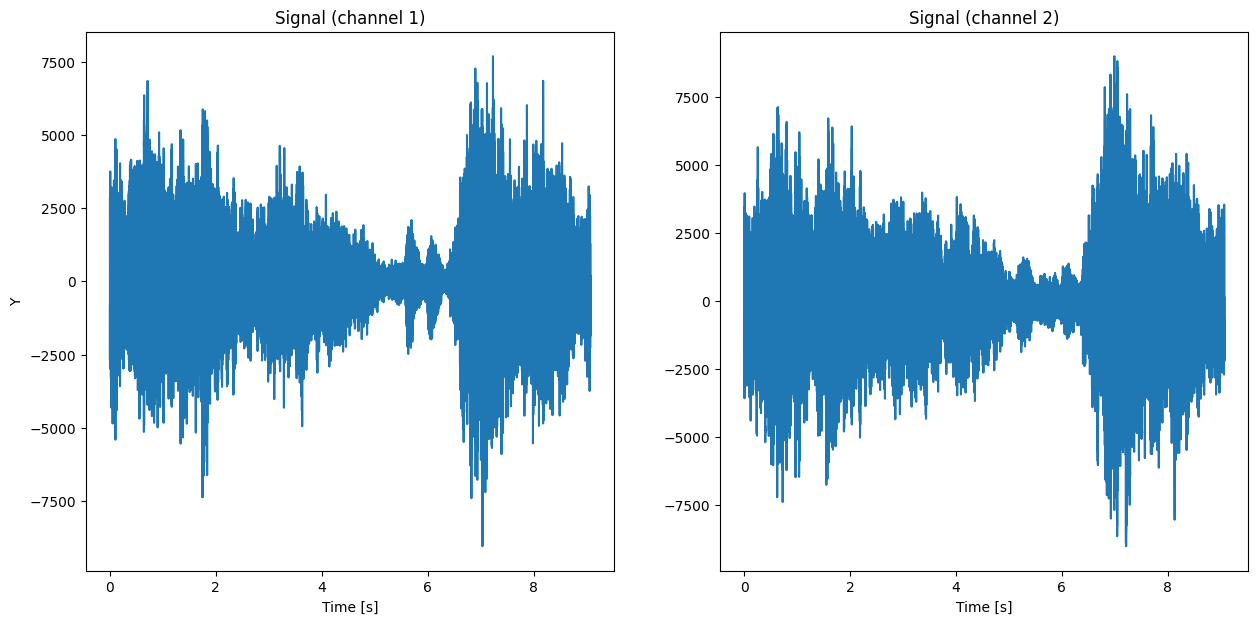

In [129]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Channel 1
axes[0].plot(t, channel_1)
axes[0].set_ylabel('Y')
axes[0].set_xlabel('Time [s]')
axes[0].set_title('Signal (channel 1)')

# Channel 2
axes[1].plot(t, channel_2)
axes[1].set_xlabel('Time [s]')
axes[1].set_title('Signal (channel 2)')

plt.show()

### Loading the Reference Pulse

A corresponding time vector is created using the previously defined sampling interval `dt`.

In [130]:
import numpy as np

# Load reference pulse
pulse = np.loadtxt('pulse.csv')

# Define time vector for the pulse
t_pulse = np.arange(0, pulse.shape[0]) * dt

### Plotting Reference Pulse

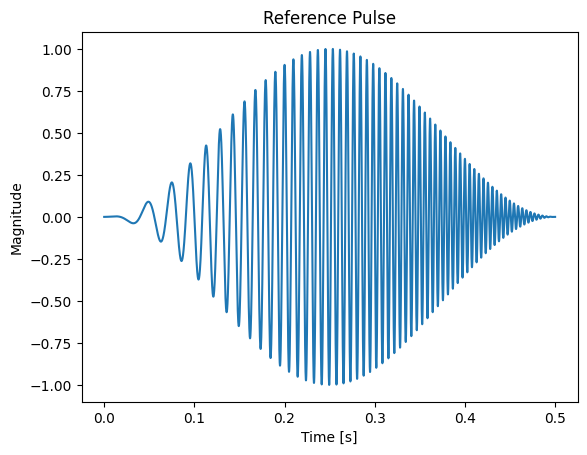

In [131]:
plt.plot(t_pulse, pulse)

plt.ylabel('Magnitude')
plt.xlabel('Time [s]')
plt.title('Reference Pulse')

plt.show()

In the chart above we can see the reference impulse, which will be used for matched filtering.
This impulse is hidden somewhere on both channels of signal.

### Identifying the Frequency Range of the Reference Pulse  

The estimated frequency range of the reference signal allows us to predict the expected time-domain resolution of the correlation result.  
Since the reference signal occupies a wide frequency band, the corresponding correlation peak in the time domain is expected to be narrow.  
The broader the frequency content, the more localized the signal is in time after correlation.

In [132]:
N_pulse = pulse.shape[0]                           # Pulse length
Yf_pulse = (abs(np.fft.fft(pulse)) / N_pulse) * 2  # Fourier transformation for reference signal
df_pulse = fs / N_pulse                            # Frequency resolution
fv_pulse = np.arange(0, N_pulse) * df_pulse        # Frequency vector

### Plotting the spectrum of the Pulse signal

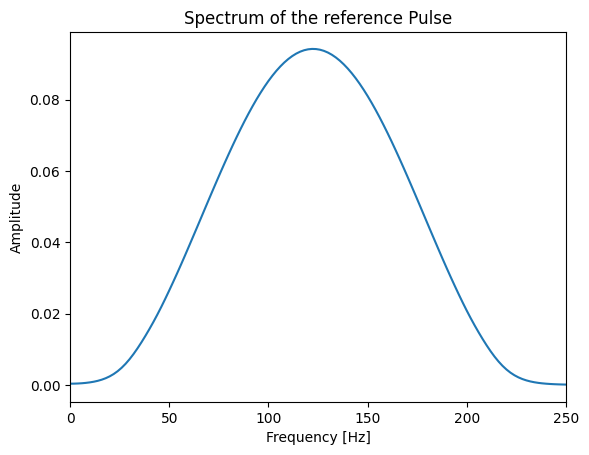

In [133]:
plt.plot(fv_pulse[:int(fv_pulse.shape[0] / 2)], Yf_pulse[:int(fv_pulse.shape[0] / 2)])
plt.ylabel('Amplitude')
plt.xlabel('Frequency [Hz]')
plt.xlim([0, 250])

plt.title('Spectrum of the reference Pulse')

plt.show()

The spectrum shows that the reference signal occupies a quite wide frequency range, approximately from 30Hz to 230Hz, so we can expect that the correlation peak will be narrow.

### Calculating the correlation between the channels and the reference pulse.

The correlation will be calculated using the convolve function. The calculation of correlation using the convolve function is explained in the file lab_2_1 in task 1.1.

In [134]:
from scipy.signal import convolve

# Calculate correlations using convolution with reversed pulse (matched filtering)
corr_ch1 = convolve(channel_1, pulse[::-1])  # Correlation between between channel 1 and the reference pulse
corr_ch2 = convolve(channel_2, pulse[::-1])  # Correlation between between channel 2 and the reference pulse

# Define time vector for the correlations
t_corr = np.arange(0, channel_1.shape[0] + pulse.shape[0] - 1) * dt

### Plotting the correlations

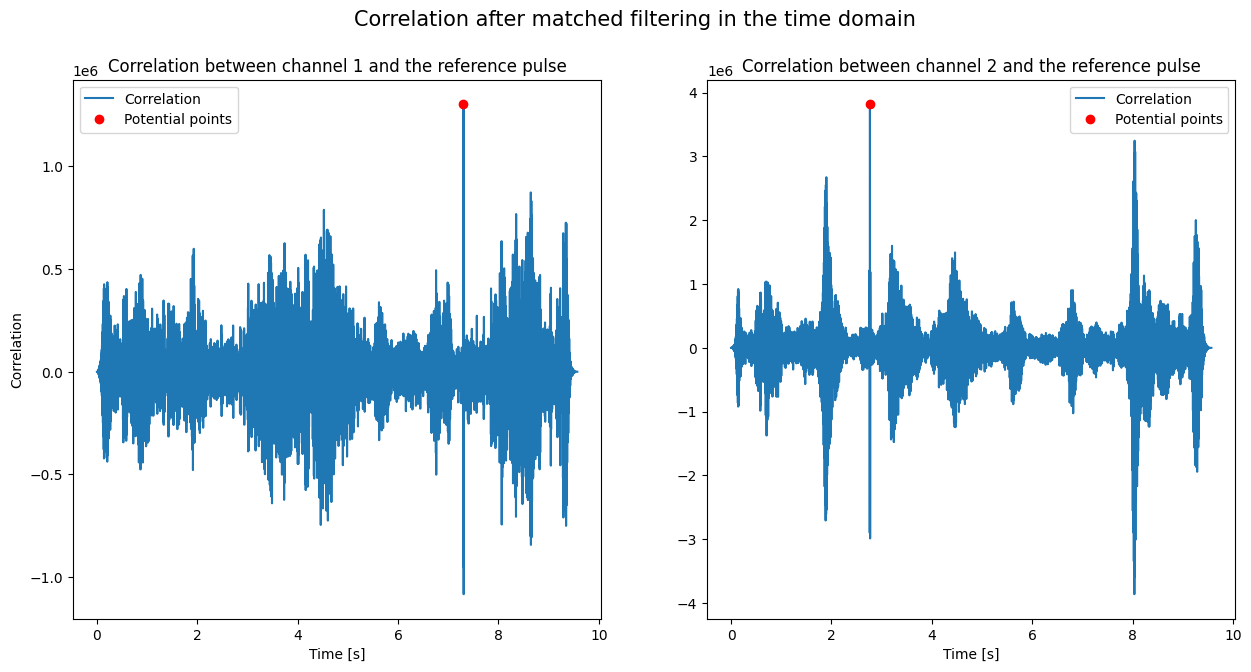

In [135]:
from scipy.signal import find_peaks

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Plot the Correlation between Channel 1 and Reference Pulse
axes[0].plot(t_corr, corr_ch1, label='Correlation')
axes[0].set_ylabel('Correlation')
axes[0].set_xlabel('Time [s]')
axes[0].set_title('Correlation between channel 1 and the reference pulse')

peaks_1, properties_1 = find_peaks(corr_ch1, height=1*1e6)
impulse_positions_1 = t_corr[peaks_1]
impulse_amplitudes_1 = properties_1['peak_heights']

axes[0].plot(impulse_positions_1, impulse_amplitudes_1, 'ro', label='Potential points')

axes[0].legend()

# Plot the Correlation between Channel 1 and Reference Pulse
axes[1].plot(t_corr, corr_ch2, label='Correlation')
axes[1].set_xlabel('Time [s]')
axes[1].set_title('Correlation between channel 2 and the reference pulse')

peaks_2, properties_2 = find_peaks(corr_ch2, height=3.5*1e6)
impulse_positions_2 = t_corr[peaks_2]
impulse_amplitudes_2 = properties_2['peak_heights']

axes[1].plot(impulse_positions_2, impulse_amplitudes_2, 'ro', label='Potential points')

axes[1].legend()

fig.suptitle('Correlation after matched filtering in the time domain', fontsize=15)

plt.show()

In the charts above we see 2 potential points where the Pulse where our looking for Pulse could be located.  
below we will zoom in on the surroundings of these points to assess if this is indeed our desired signal.

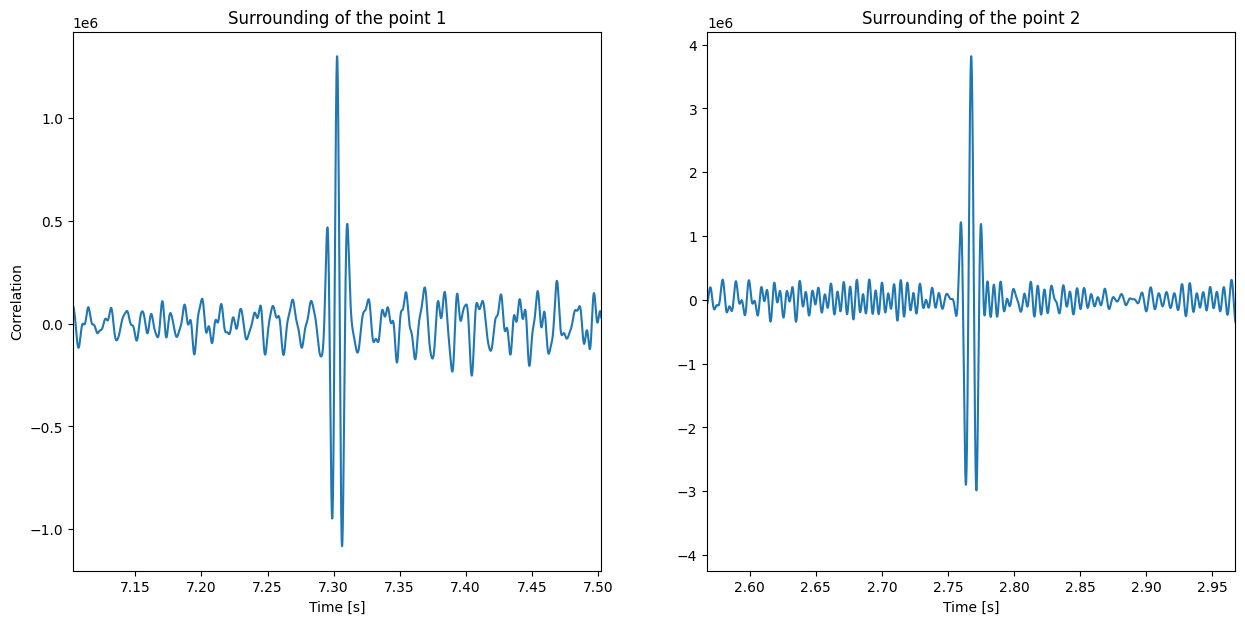

In [136]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Plot the Correlation between Channel 1 and Reference Pulse
axes[0].plot(t_corr, corr_ch1)
axes[0].set_ylabel('Correlation')
axes[0].set_xlabel('Time [s]')
axes[0].set_title('Surrounding of the point 1')

surrounding_peak_1 = [impulse_positions_1 - 0.2, impulse_positions_1 + 0.2]
axes[0].set_xlim(surrounding_peak_1)

# Plot the Correlation between Channel 1 and Reference Pulse
axes[1].plot(t_corr, corr_ch2)
axes[1].set_xlabel('Time [s]')
axes[1].set_title('Surrounding of the point 2')

surrounding_peak_2 = [impulse_positions_2 - 0.2, impulse_positions_2 + 0.2]
axes[1].set_xlim(surrounding_peak_2)

plt.show()

These correlation peaks look pretty good, their time domain is narrow, and the correlation values for these peaks are high, so all seems to that our looking for impulse being in these places.

## Task 2

In this task we must first calculate the correlation in the frequency domain, and then perform the inverse Fourier transform to return to the time domain.

### Calculating the correlation in the frequency domain

In [137]:
from scipy.fft import fft, ifft

# Define the time vector
N = channel_1.shape[0]
Np = pulse.shape[0]
t = np.arange(N) * dt

# Padding to the same range as the signal
pulse_padded = np.concatenate([pulse, np.zeros(N - Np)])

# Fourier ransform for the Signal Channels
yf_1 = fft(channel_1)
yf_2 = fft(channel_2)

# Fourier transform for Reference Pulse
ypf = fft(pulse_padded)

# Calculating the correlations between Channels and Reference Pulse 
yf_1_inv = yf_1 * np.conj(ypf)
yf_2_inv = yf_2 * np.conj(ypf)

### Returning to the time domain

In [138]:
y_1 = ifft(yf_1_inv)
y_2 = ifft(yf_2_inv)

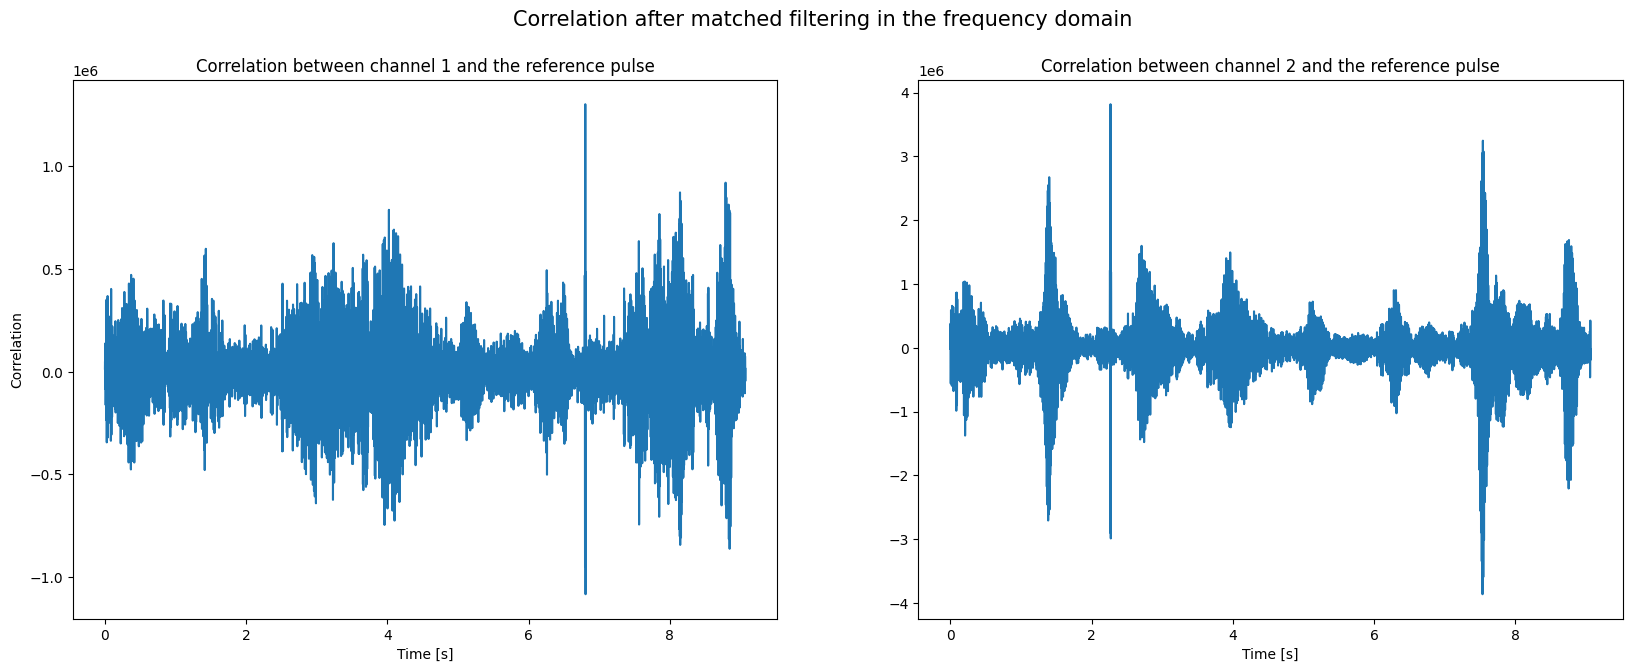

In [139]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

axes[0].plot(t, y_1)
axes[0].set_ylabel('Correlation')
axes[0].set_xlabel('Time [s]')
axes[0].set_title('Correlation between channel 1 and the reference pulse')

axes[1].plot(t, y_2)
axes[1].set_xlabel('Time [s]')
axes[1].set_title('Correlation between channel 2 and the reference pulse')


fig.suptitle('Correlation after matched filtering in the frequency domain', fontsize=15)
plt.show()

# Conclusions

The charts we obtained by calculating correlation in the time domain and those that were obtained by calculating correlation in the frequency domain and transformed to the time domain are the same.